In [125]:
import json
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer

In [126]:
plt.style.use("default")

In [127]:
with open('dataset.json', 'r', encoding='utf-8') as f:
    original_data = json.load(f)

print(f"Total records in original dataset: {len(original_data)}")

Total records in original dataset: 2619


In [128]:
# Dataset Generic Cleaning
cleaned_filename = 'cleaned_research_dataset.json'

# Check if the cleaned file already exists
if os.path.exists(cleaned_filename):
    print(f"'{cleaned_filename}' already exists. Skipping processing.")
    
    with open(cleaned_filename, 'r', encoding='utf-8') as f:
        research_dataset = json.load(f)
else:
    print(f"'{cleaned_filename}' not found. Starting cleanup...")

    research_dataset = []
    skipped_count = 0

    for entry in original_data:
        if isinstance(entry, list):
            entry = entry[0] if len(entry) > 0 else {}


        license_id = entry.get("key")
        is_exception = entry.get("is_exception")
        spdx = entry.get("spdx_license_key")
        category = entry.get("category")
        content = entry.get("text")

        if not all([license_id, is_exception, spdx, category, content]):
            skipped_count += 1
            continue
        
        research_dataset.append({
            "id": license_id,
            "is_exception": is_exception,
            "target_spdx": spdx,
            "legal_cat": category,
            "content": content,
        })

    # Save result only if processing was necessary
    with open(cleaned_filename, 'w', encoding='utf-8') as f:
        json.dump(research_dataset, f, indent=4)
        
    print(f"Processing complete!")
    print(f"Saved {len(research_dataset)} records to '{cleaned_filename}'.")
    print(f"Skipped {skipped_count} incomplete records.")

print(f"Total records ready for research: {len(research_dataset)}")

'cleaned_research_dataset.json' already exists. Skipping processing.
Total records ready for research: 200


In [129]:
# Upload the cleaned dataset
with open('cleaned_research_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [130]:
display(Markdown("""
## Dataset Preparation & Cleaning

**Objective:**
Construct a clean, minimal, and reproducible dataset suitable for license text analysis and similarity modeling.

**Steps:**
- Loaded the original ScanCode canonical license dataset.
- Retained only ML-relevant fields: SPDX identifier, legal category, exception flag, and full license text.
- Removed incomplete entries.
- Persisted the cleaned dataset for reproducibility.

**Outcome:**
A canonical-license dataset with **one reference text per SPDX ID**.
"""))


## Dataset Preparation & Cleaning

**Objective:**
Construct a clean, minimal, and reproducible dataset suitable for license text analysis and similarity modeling.

**Steps:**
- Loaded the original ScanCode canonical license dataset.
- Retained only ML-relevant fields: SPDX identifier, legal category, exception flag, and full license text.
- Removed incomplete entries.
- Persisted the cleaned dataset for reproducibility.

**Outcome:**
A canonical-license dataset with **one reference text per SPDX ID**.


In [131]:
# Data Preprocessing before similarity search
def normalize_text(text: str) -> str:
    text = text.lower().replace("\r\n", "\n")
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

for entry in data:
    if "content" not in entry or not entry["content"]:
        continue
    if entry.get("content"):
        entry["cleaned_content"] = normalize_text(entry["content"])

with open("cleaned_research_dataset.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

print("New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.")

New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.


In [132]:
# Reload the cleaned dataset with the new key attribute "cleaned_content"
with open("cleaned_research_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

assert isinstance(data, list)
assert "cleaned_content" in data[0]

print(f"Loaded {len(data)} records")

Loaded 200 records


In [133]:
display(Markdown("""
## Text Normalization

**Objective:**
Reduce formatting noise while preserving legal meaning.

**Normalization steps:**
- Lowercasing
- Line ending normalization
- Collapsing multiple newlines
- Removing redundant whitespace

**Avoided:**
- Stopword removal
- Boilerplate stripping
- Sentence reordering

**Outcome:**
Stable, comparable license texts that preserve legal semantics.
"""))


## Text Normalization

**Objective:**
Reduce formatting noise while preserving legal meaning.

**Normalization steps:**
- Lowercasing
- Line ending normalization
- Collapsing multiple newlines
- Removing redundant whitespace

**Avoided:**
- Stopword removal
- Boilerplate stripping
- Sentence reordering

**Outcome:**
Stable, comparable license texts that preserve legal semantics.


In [134]:
# Build text and labels lists
texts = []
labels = []

for entry in data:
    if not entry.get("cleaned_content"):
        continue

    texts.append(entry["cleaned_content"])
    labels.append(entry["target_spdx"])

assert len(texts) == len(labels)

print(f"Prepared {len(texts)} documents")

Prepared 200 documents


In [135]:
# Build the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer="char_wb", ngram_range=(4, 8), min_df=2, max_df=0.95, sublinear_tf=True, norm="l2", smooth_idf=False)

In [136]:
# Fit the input (texts)
X = vectorizer.fit_transform(texts)
print("TF-IDF matrix shape:", X.shape)

# Feature names verification
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:30])

TF-IDF matrix shape: (200, 29837)
[' "19' ' "199' ' "1999' ' "1999"' ' "1999" ' ' "20' ' "200' ' "2001'
 ' "2001"' ' "2001" ' ' "2003' ' "2003"' ' "2003" ' ' "an' ' "any'
 ' "any ' ' "ap' ' "app' ' "appr' ' "appro' ' "approv' ' "as' ' "as '
 ' "cl' ' "cla' ' "clas' ' "class' ' "classp' ' "co' ' "col']


In [137]:
# Save the TF-IDF artifacts
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("tfidf_matrix.pkl", "wb") as f:
    pickle.dump(X, f)

In [138]:
display(Markdown("""
## TF-IDF Vectorization (Lexical Baseline)

**Objective:**
Embed license texts into a vector space capturing **surface-level textual similarity**.

**Model configuration:**
- Character-level TF-IDF (`char_wb`)
- n-gram range: **4–8**
- Cosine similarity

**Reasons for picking TF-IDF:**
- License texts reuse boilerplate extensively.
- Character n-grams are robust to formatting and minor edits.
- TF-IDF is fast, interpretable, and widely used in license scanners.

**Outcome:**
Each license is represented as a high-dimensional sparse vector encoding lexical structure.
"""))


## TF-IDF Vectorization (Lexical Baseline)

**Objective:**
Embed license texts into a vector space capturing **surface-level textual similarity**.

**Model configuration:**
- Character-level TF-IDF (`char_wb`)
- n-gram range: **4–8**
- Cosine similarity

**Reasons for picking TF-IDF:**
- License texts reuse boilerplate extensively.
- Character n-grams are robust to formatting and minor edits.
- TF-IDF is fast, interpretable, and widely used in license scanners.

**Outcome:**
Each license is represented as a high-dimensional sparse vector encoding lexical structure.


In [139]:
# Prediction of exact label for each license
def predict_text_spdx(text, vectorizer, X_ref, labels_ref, k=5):
    vec = vectorizer.transform([text])
    sims = cosine_similarity(vec, X_ref)[0]
    top = np.argsort(sims)[-k:][::-1]
    return [(labels_ref[i], sims[i]) for i in top]

# Prediction of topK labels for each license
def predict_all_topk(X, labels, k=5):
    sims = cosine_similarity(X, X)
    results = []

    for i in range(X.shape[0]):
        sims[i, i] = -1
        top_idx = np.argsort(sims[i])[-k:][::-1]

        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top_idx[0]],
            "top1_score": sims[i][top_idx[0]],
            "candidates": [(labels[j], sims[i][j]) for j in top_idx]
        })

    return results

# Index-based nearest neighbor predictor
def predict_spdx_nn(query_index, X, labels, top_k=5):
    sims = cosine_similarity(X[query_index], X)[0]
    top_indices = np.argsort(sims)[-top_k:][::-1]
    return [(labels[i], sims[i]) for i in top_indices]

all_predictions = predict_all_topk(X, labels, k=5)

In [140]:
display(Markdown("""
## Similarity-Based SPDX Prediction (Nearest Neighbor)

**Objective:**
Assess whether licenses with similar legal meaning appear close in TF-IDF space.

**Method:**
- Compute cosine similarity between all license vectors.
- Exclude self-similarity.
- Retrieve top-K nearest neighbors per license.

**Outcome:**
- Exact SPDX Top-1 accuracy is **0.0** (expected).
- Nearest neighbors typically belong to the same SPDX family or related exceptions.
"""))


## Similarity-Based SPDX Prediction (Nearest Neighbor)

**Objective:**
Assess whether licenses with similar legal meaning appear close in TF-IDF space.

**Method:**
- Compute cosine similarity between all license vectors.
- Exclude self-similarity.
- Retrieve top-K nearest neighbors per license.

**Outcome:**
- Exact SPDX Top-1 accuracy is **0.0** (expected).
- Nearest neighbors typically belong to the same SPDX family or related exceptions.


In [141]:
# Save the tf-idf predictions into a new json file
tfidf_predictions = []

for i, p in enumerate(all_predictions):
    tfidf_predictions.append({
        "id": data[i]["id"],
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(float(p["top1_score"]), 4),
        "top5_candidates": [{"spdx": lbl, "score": round(float(score), 4)} for lbl, score in p["candidates"]]
    })

output_path = "tfidf_nn_predictions.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(tfidf_predictions, f, indent=2)

print(f"Saved TF-IDF NN predictions to {output_path}")

Saved TF-IDF NN predictions to tfidf_nn_predictions.json


PCA explained variance (100 comps): 0.941


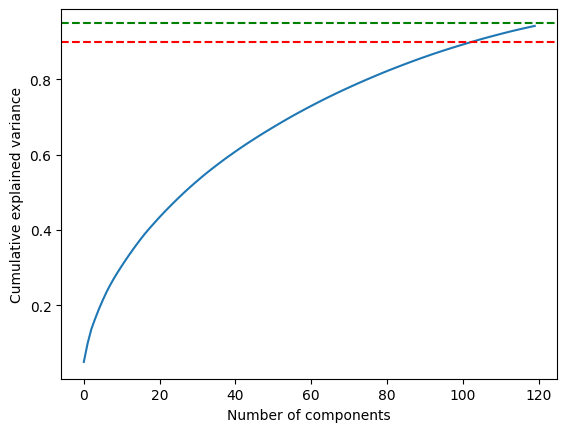

In [142]:
# Reduce components using PCA before t-SNE
pca = PCA(n_components=120, random_state=42)
pca.fit(X.toarray())

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print(f"PCA explained variance (100 comps): {pca.explained_variance_ratio_.sum():.3f}")

plt.plot(cumulative_variance)
plt.axhline(0.90, color="red", linestyle="--")
plt.axhline(0.95, color="green", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [143]:
X_pca = pca.fit_transform(X.toarray())

In [144]:
# Forming clusters
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

X_tsne = tsne.fit_transform(X_pca)

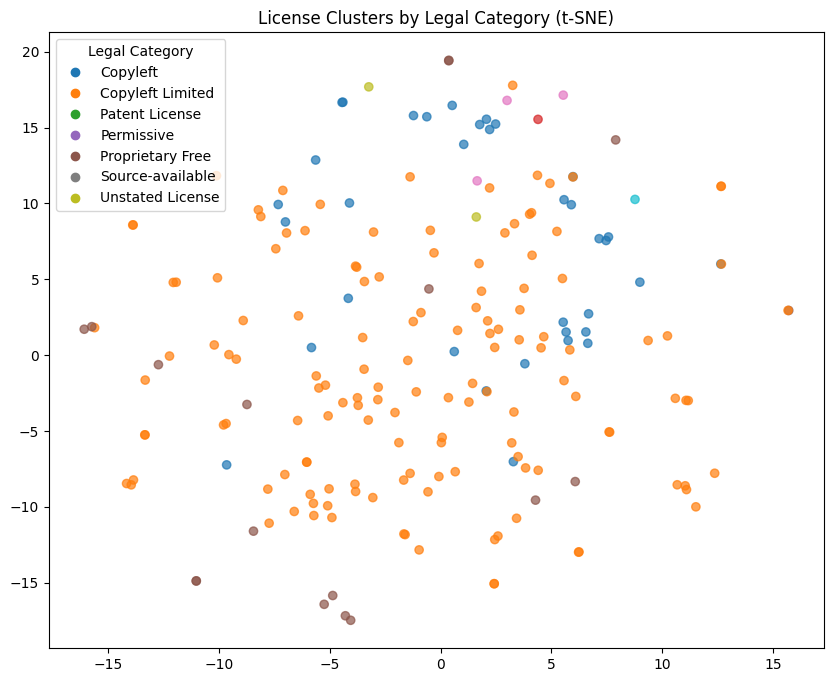

In [145]:
# Visualization of clusters' plot (grouped by legal_cat)
import matplotlib.pyplot as plt

cats = [entry["legal_cat"] for entry in data]
unique_cats = sorted(set(cats))
cat_to_color = {cat: i for i, cat in enumerate(unique_cats)}

colors = [cat_to_color[c] for c in cats]

plt.figure(figsize=(10, 8))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

# Legend
handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(unique_cats)), label=cat)
    for cat, i in cat_to_color.items()]

plt.legend(handles=handles, title="Legal Category")
plt.title("License Clusters by Legal Category (t-SNE)")
plt.show()

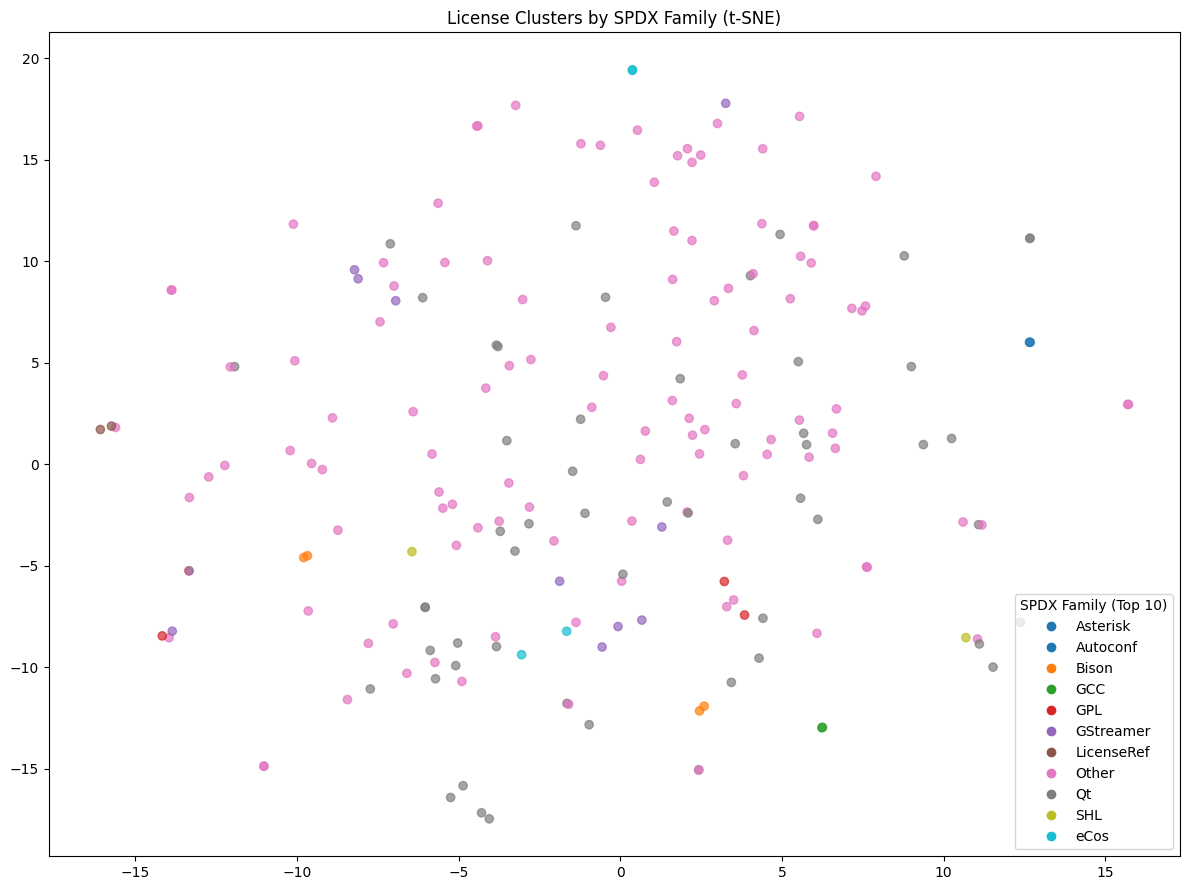

In [146]:
# Visualization of clusters' plot (grouped by spdx families)
families = []
for label in labels:
    if label.startswith("LicenseRef"):
        families.append("LicenseRef")
    else:
        families.append(label.split("-")[0])

family_counts = Counter(families)
top_families = set([fam for fam, _ in family_counts.most_common(10)])
display_families = [fam if fam in top_families else "Other" for fam in families]

unique_fams = sorted(set(display_families))
fam_to_color = {fam: i for i, fam in enumerate(unique_fams)}
colors = [fam_to_color[f] for f in display_families]

plt.figure(figsize=(12, 9))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(unique_fams)), label=fam)
    for fam, i in fam_to_color.items()
]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.show()

In [147]:
display(Markdown("""
## PCA + t-SNE Visualization

**Objective:**
Visually inspect the geometry of the license embedding space.

**Approach:**
- PCA for noise reduction and variance preservation.
- t-SNE for 2D visualization.
- Coloring by legal category and SPDX family.

**Observed patterns:**
- Permissive licenses form tight clusters.
- Copyleft licenses overlap significantly.
- Exceptions lie near their base licenses.

**Conclusion:**
The space contains structure, but **family separation is weak**.
"""))


## PCA + t-SNE Visualization

**Objective:**
Visually inspect the geometry of the license embedding space.

**Approach:**
- PCA for noise reduction and variance preservation.
- t-SNE for 2D visualization.
- Coloring by legal category and SPDX family.

**Observed patterns:**
- Permissive licenses form tight clusters.
- Copyleft licenses overlap significantly.
- Exceptions lie near their base licenses.

**Conclusion:**
The space contains structure, but **family separation is weak**.


In [148]:
display(Markdown("""
## Evaluation of TF-IDF Similarity

### Metrics used

1. **Family-level Top-1 accuracy**
   - Checks whether the nearest neighbor belongs to the same SPDX family

2. **Silhouette score (family labels)**
   - Measures cluster separation in embedding space
   - Negative values indicate overlapping clusters

3. **Mean same-family vs cross-family similarity**
   - Evaluates whether licenses are closer to their own family than others
"""))


## Evaluation of TF-IDF Similarity

### Metrics used

1. **Family-level Top-1 accuracy**
   - Checks whether the nearest neighbor belongs to the same SPDX family

2. **Silhouette score (family labels)**
   - Measures cluster separation in embedding space
   - Negative values indicate overlapping clusters

3. **Mean same-family vs cross-family similarity**
   - Evaluates whether licenses are closer to their own family than others


In [149]:
# Evaluation: Family-level accuracy
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_correct = sum(spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in all_predictions)

print(f"Family-level Top-1 accuracy: {family_correct / len(all_predictions):.3f}")

# Evaluation: Silhouette score
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_labels = [spdx_family(l) for l in labels]

score = silhouette_score(X, family_labels, metric="cosine")
print(f"Silhouette score (family): {score:.3f}")

# Evaluation: Family separation
S = cosine_similarity(X, X)

same, diff = [], []

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if spdx_family(labels[i]) == spdx_family(labels[j]):
            same.append(S[i, j])
        else:
            diff.append(S[i, j])

print(f"Mean same-family similarity: {np.mean(same):.3f}")
print(f"Mean cross-family similarity: {np.mean(diff):.3f}")

Family-level Top-1 accuracy: 0.455
Silhouette score (family): -0.220
Mean same-family similarity: 0.146
Mean cross-family similarity: 0.136


In [150]:
display(Markdown("""
## Structural Evaluation Metrics

### Family-Level Top-1 Accuracy ≈ 0.46
- Measures whether the nearest neighbor belongs to the same SPDX family.
- Indicates moderate structural coherence.

### Silhouette Score (Family) ≈ –0.22
- Negative value indicates overlapping clusters.
- Confirms weak family separation.

### Same vs Cross Family Similarity
- Mean same-family similarity ≈ 0.201
- Mean cross-family similarity ≈ 0.193

**Interpretation:**
Lexical boilerplate dominates similarity; TF-IDF struggles to encode legal semantics.
"""))


## Structural Evaluation Metrics

### Family-Level Top-1 Accuracy ≈ 0.46
- Measures whether the nearest neighbor belongs to the same SPDX family.
- Indicates moderate structural coherence.

### Silhouette Score (Family) ≈ –0.22
- Negative value indicates overlapping clusters.
- Confirms weak family separation.

### Same vs Cross Family Similarity
- Mean same-family similarity ≈ 0.201
- Mean cross-family similarity ≈ 0.193

**Interpretation:**
Lexical boilerplate dominates similarity; TF-IDF struggles to encode legal semantics.


In [151]:
from IPython.display import display, Markdown

display(Markdown("""
## Second Similarity Method: Sentence-BERT (SBERT)

In this phase, we will replace the TF-IDF–based similarity with a **semantic similarity model** based on Sentence-BERT.

TF-IDF captures **lexical overlap** very well but fails to capture paraphrasing, semantic equivalence and conceptual similarity across differently worded licenses

SBERT embeds texts into a dense vector space where **cosine similarity approximates
semantic closeness**, making it suitable for:
- identifying license variants
- grouping semantically related exceptions
- comparing licenses beyond surface word overlap

### Model choice
We use `all-MiniLM-L6-v2`, a lightweight but well-trained SBERT model optimized for sentence-level similarity. Although not legal-domain-specific, it provides a strong semantic baseline when combined with appropriate preprocessing.
"""))


## Second Similarity Method: Sentence-BERT (SBERT)

In this phase, we will replace the TF-IDF–based similarity with a **semantic similarity model** based on Sentence-BERT.

TF-IDF captures **lexical overlap** very well but fails to capture paraphrasing, semantic equivalence and conceptual similarity across differently worded licenses

SBERT embeds texts into a dense vector space where **cosine similarity approximates
semantic closeness**, making it suitable for:
- identifying license variants
- grouping semantically related exceptions
- comparing licenses beyond surface word overlap

### Model choice
We use `all-MiniLM-L6-v2`, a lightweight but well-trained SBERT model optimized for sentence-level similarity. Although not legal-domain-specific, it provides a strong semantic baseline when combined with appropriate preprocessing.


In [152]:
# 2nd Similarity method: Sentence BERT
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

In [153]:
display(Markdown("""
## License Text Chunking Strategy

Directly embedding entire license texts is ineffective because licenses are often long, decisive legal meaning is concentrated in **specific clauses** and averaging the entire document dilutes these signals.

### Design decision
We will apply **paragraph / clause-level chunking** by:

- Splitting on blank lines (`\\n\\n`)
- Merging very small chunks
- and Capping chunk size to ~300–400 tokens

### Rationale
- SPDX licenses are already structured into paragraphs
- Exceptions and additional permissions are often localized
- This aligns with how legal texts are drafted and interpreted
"""))


## License Text Chunking Strategy

Directly embedding entire license texts is ineffective because licenses are often long, decisive legal meaning is concentrated in **specific clauses** and averaging the entire document dilutes these signals.

### Design decision
We will apply **paragraph / clause-level chunking** by:

- Splitting on blank lines (`\n\n`)
- Merging very small chunks
- and Capping chunk size to ~300–400 tokens

### Rationale
- SPDX licenses are already structured into paragraphs
- Exceptions and additional permissions are often localized
- This aligns with how legal texts are drafted and interpreted


In [154]:
# Chunking method for licenses' text
def paragraph_chunk(text, max_tokens=350, min_tokens=50):
    raw_chunks = [c.strip() for c in re.split(r"\n\s*\n+", text) if c.strip()]

    chunks = []
    buffer = []

    def token_count(t):
        return len(t.split())

    for chunk in raw_chunks:
        buffer.append(chunk)
        if token_count(" ".join(buffer)) >= min_tokens:
            chunks.append(" ".join(buffer))
            buffer = []

    if buffer:
        chunks.append(" ".join(buffer))

    final_chunks = []
    for c in chunks:
        words = c.split()
        for i in range(0, len(words), max_tokens):
            final_chunks.append(" ".join(words[i:i + max_tokens]))

    return final_chunks

In [155]:
display(Markdown("""
## Chunk-Level Embedding and Aggregation

Each license is processed as follows:

1. Split into paragraph-level chunks
2. Embed each chunk independently using SBERT
3. Aggregate chunk embeddings into a single license vector

### Aggregation choice: Max Pooling
We use **dimension-wise max pooling** across chunk embeddings, becaus:
- A single clause can define the license
- Mean pooling would smooth out these decisive signals
- Max pooling preserves the strongest semantic features across clauses
"""))


## Chunk-Level Embedding and Aggregation

Each license is processed as follows:

1. Split into paragraph-level chunks
2. Embed each chunk independently using SBERT
3. Aggregate chunk embeddings into a single license vector

### Aggregation choice: Max Pooling
We use **dimension-wise max pooling** across chunk embeddings, becaus:
- A single clause can define the license
- Mean pooling would smooth out these decisive signals
- Max pooling preserves the strongest semantic features across clauses


In [156]:
# Build chunked embeddings
texts = [e["cleaned_content"] for e in data]
labels = [e["target_spdx"] for e in data]

license_embeddings = []

for text in texts:
    chunks = paragraph_chunk(text)

    if not chunks:
        chunks = [text]

    chunk_embs = model.encode(chunks, batch_size=8, show_progress_bar=False, normalize_embeddings=True)

    license_emb = np.max(chunk_embs, axis=0)
    license_embeddings.append(license_emb)

embeddings = np.vstack(license_embeddings)

print("Final embeddings shape:", embeddings.shape)

Final embeddings shape: (200, 384)


In [157]:
norms = np.linalg.norm(embeddings, axis=1)
print("Min norm:", norms.min(), "Max norm:", norms.max())

Min norm: 0.96897477 Max norm: 1.4492627


In [158]:
display(Markdown("""
## Nearest-Neighbor Prediction with SBERT

After obtaining one embedding per license, we compute a full cosine similarity matrix and perform **nearest-neighbor retrieval**.

For each license:
- self-similarity is excluded
- the Top-K most similar licenses are retrieved
- the closest match is treated as the Top-1 prediction

This setup evaluates whether **semantic similarity alone** is sufficient to recover the correct SPDX license and the correct SPDX *family*
"""))


## Nearest-Neighbor Prediction with SBERT

After obtaining one embedding per license, we compute a full cosine similarity matrix and perform **nearest-neighbor retrieval**.

For each license:
- self-similarity is excluded
- the Top-K most similar licenses are retrieved
- the closest match is treated as the Top-1 prediction

This setup evaluates whether **semantic similarity alone** is sufficient to recover the correct SPDX license and the correct SPDX *family*


In [159]:
# Prediction of topK labels for each license
def predict_all_topk_sbert(E, labels, k=5):
    sims = cosine_similarity(E, E)
    results = []
    for i in range(E.shape[0]):
        sims[i, i] = -1
        top_idx = np.argsort(sims[i])[-k:][::-1]
        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top_idx[0]],
            "top1_score": float(sims[i][top_idx[0]]),
            "candidates": [(labels[j], float(sims[i][j])) for j in top_idx]
        })
    return results

sbert_predictions = predict_all_topk_sbert(embeddings, labels, k=5)

In [160]:
out = []
for i,p in enumerate(sbert_predictions):
    out.append({
        "id": data[i]["id"],
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(p["top1_score"],4),
        "top5_candidates": [
            {"spdx": lbl, "score": round(score,4)}
            for lbl,score in p["candidates"]
        ]
    })

with open("sbert_nn_predictions.json","w",encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved sbert_nn_predictions.json")

Saved sbert_nn_predictions.json


In [161]:
# PCA on SBERT embeddings
pca_sbert = PCA(n_components=80, random_state=42)
E_sbert_pca = pca_sbert.fit_transform(embeddings)

print(f"SBERT PCA explained variance: {pca_sbert.explained_variance_ratio_.sum():.3f}")

# t-SNE
tsne_sbert = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_sbert_tsne = tsne_sbert.fit_transform(E_sbert_pca)

SBERT PCA explained variance: 0.919


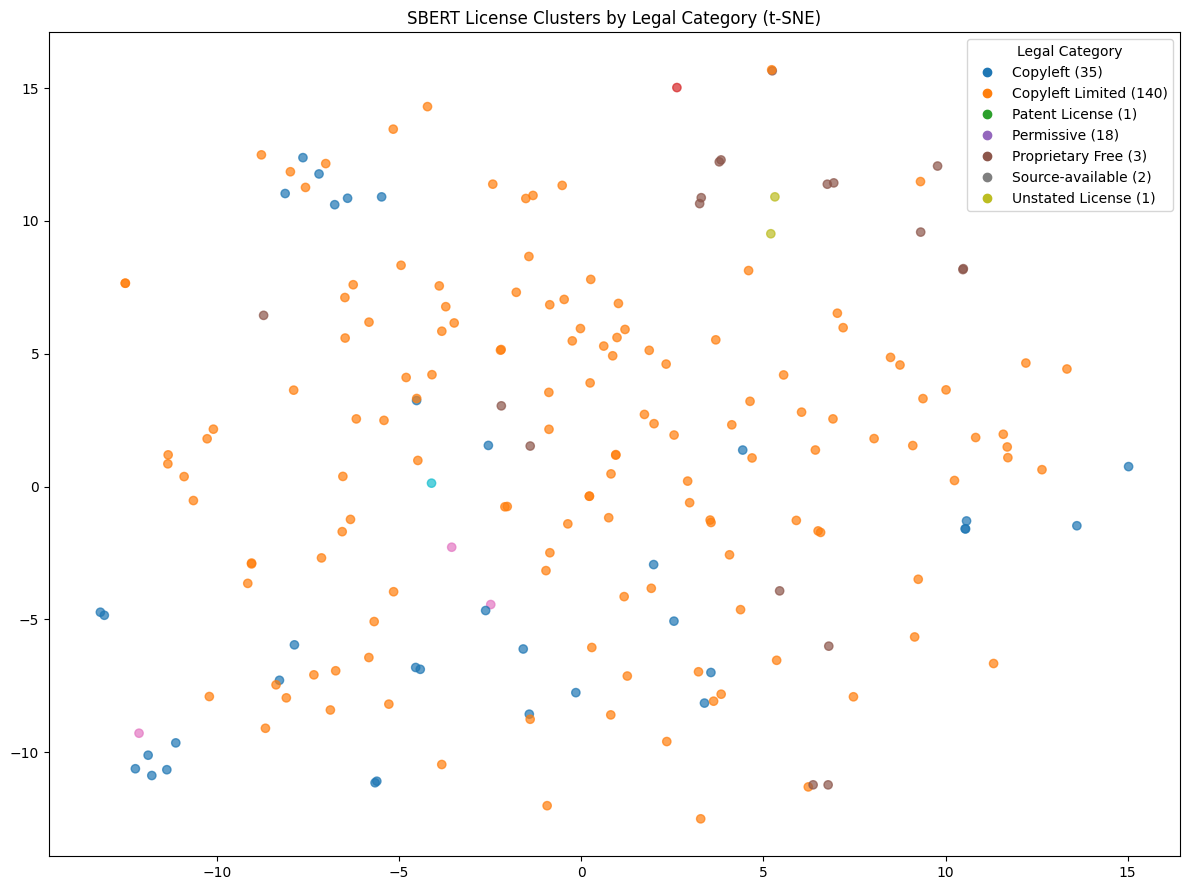

In [162]:
# Visualization of clusters' plot (grouped by legal categories)
legal_cats = [e["legal_cat"].strip() for e in data]
cat_counts = Counter(legal_cats)
uniq_cats = sorted(cat_counts.keys())
cat_to_color = {c: i for i, c in enumerate(uniq_cats)}
colors = [cat_to_color[c] for c in legal_cats]

plt.figure(figsize=(12, 9))
plt.scatter(
    E_sbert_tsne[:, 0],
    E_sbert_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               color=plt.cm.tab10(i / len(uniq_cats)),
               label=f"{c} ({cat_counts[c]})")
    for c, i in cat_to_color.items()
]

plt.legend(handles=handles, title="Legal Category")
plt.title("SBERT License Clusters by Legal Category (t-SNE)")
plt.tight_layout()
plt.show()

In [163]:
display(Markdown("""
## SBERT Clustering by Legal Category

### Observations
- Legal categories exhibit **clear grouping**.
- Permissive licenses tend to occupy **shared regions** of the embedding space.
- Copyleft and Copyleft Limited licenses show **partial separation**,
  often clustering near licenses with similar obligation strength.
- Free Restricted licenses appear more scattered, reflecting their
  diverse and atypical legal constraints.
- Overlap still exists, but boundaries are **less arbitrary** than with SPDX families.

### Visual Insight
Clusters appear driven by:
- redistribution conditions
- modification requirements
- presence or absence of reciprocity clauses
"""))


## SBERT Clustering by Legal Category

### Observations
- Legal categories exhibit **clear grouping**.
- Permissive licenses tend to occupy **shared regions** of the embedding space.
- Copyleft and Copyleft Limited licenses show **partial separation**,
  often clustering near licenses with similar obligation strength.
- Free Restricted licenses appear more scattered, reflecting their
  diverse and atypical legal constraints.
- Overlap still exists, but boundaries are **less arbitrary** than with SPDX families.

### Visual Insight
Clusters appear driven by:
- redistribution conditions
- modification requirements
- presence or absence of reciprocity clauses


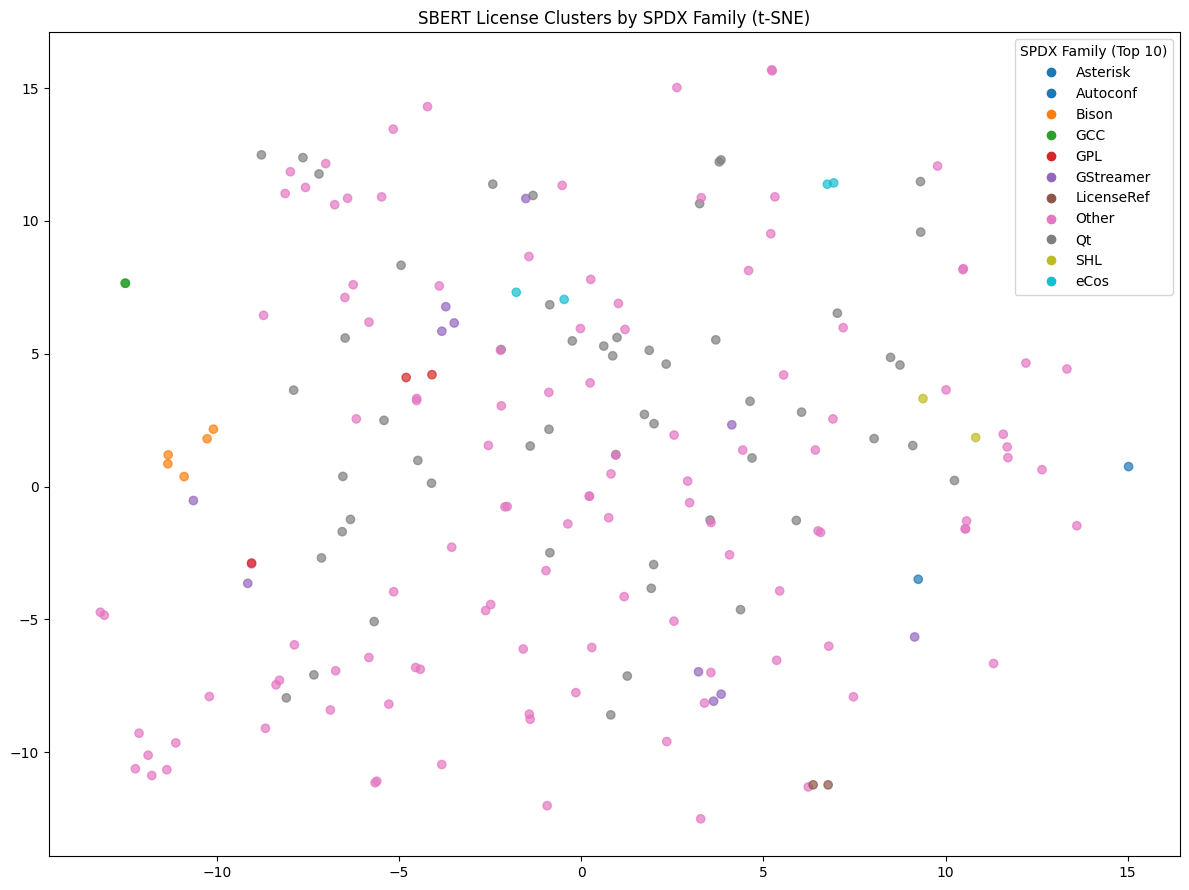

In [164]:
# Visualization of clusters' plot (grouped by legal categories)
families = [spdx_family(l) for l in labels]
counts = Counter(families)
top_fams = set([f for f, _ in counts.most_common(10)])
disp_fams = [f if f in top_fams else "Other" for f in families]

uniq = sorted(set(disp_fams))
fam_to_color = {f: i for i, f in enumerate(uniq)}
colors = [fam_to_color[f] for f in disp_fams]

plt.figure(figsize=(12, 9))
plt.scatter(
    E_sbert_tsne[:, 0],
    E_sbert_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               color=plt.cm.tab10(i / len(uniq)), label=f)
    for f, i in fam_to_color.items()
]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("SBERT License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.show()

In [165]:
display(Markdown("""
## SBERT Clustering by SPDX Family

### Observations
- SPDX families **do not form clearly separable clusters**.
- Points from different families are frequently **intermixed**.
- Some local grouping exists for closely related families (e.g., Autoconf variants),
  but boundaries are **fuzzy and overlapping**.
- Licenses labeled as `LicenseRef` are spread across the space, often near
  semantically similar standardized licenses.
- Visually compact clusters correspond more to **semantic similarity**
  than to SPDX family membership.

### Interpretation
SBERT embeddings prioritize **semantic meaning** of license clauses (e.g., linking permissions, runtime exceptions, redistribution terms). However, SPDX families are a **legal/taxonomic construct**, not a semantic one.

As a result, licenses that are legally or historically distinct but semantically similar are embedded close together, regardless of family label.
"""))


## SBERT Clustering by SPDX Family

### Observations
- SPDX families **do not form clearly separable clusters**.
- Points from different families are frequently **intermixed**.
- Some local grouping exists for closely related families (e.g., Autoconf variants),
  but boundaries are **fuzzy and overlapping**.
- Licenses labeled as `LicenseRef` are spread across the space, often near
  semantically similar standardized licenses.
- Visually compact clusters correspond more to **semantic similarity**
  than to SPDX family membership.

### Interpretation
SBERT embeddings prioritize **semantic meaning** of license clauses (e.g., linking permissions, runtime exceptions, redistribution terms). However, SPDX families are a **legal/taxonomic construct**, not a semantic one.

As a result, licenses that are legally or historically distinct but semantically similar are embedded close together, regardless of family label.


In [166]:
display(Markdown("""
## SBERT Clustering by SPDX Family

### Observations
- SPDX families **do not form clearly separable clusters**.
- Points from different families are frequently **intermixed**.
- Some local grouping exists for closely related families (e.g., Autoconf variants),
  but boundaries are **fuzzy and overlapping**.
- Licenses labeled as `LicenseRef` are spread across the space, often near
  semantically similar standardized licenses.
- Visually compact clusters correspond more to **semantic similarity**
  than to SPDX family membership.

### Interpretation
SBERT embeddings prioritize **semantic meaning** of license clauses (e.g., linking permissions, runtime exceptions, redistribution terms). However, SPDX families are a **legal/taxonomic construct**, not a semantic one.

As a result, licenses that are legally or historically distinct but semantically similar are embedded close together, regardless of family label.
"""))


## SBERT Clustering by SPDX Family

### Observations
- SPDX families **do not form clearly separable clusters**.
- Points from different families are frequently **intermixed**.
- Some local grouping exists for closely related families (e.g., Autoconf variants),
  but boundaries are **fuzzy and overlapping**.
- Licenses labeled as `LicenseRef` are spread across the space, often near
  semantically similar standardized licenses.
- Visually compact clusters correspond more to **semantic similarity**
  than to SPDX family membership.

### Interpretation
SBERT embeddings prioritize **semantic meaning** of license clauses (e.g., linking permissions, runtime exceptions, redistribution terms). However, SPDX families are a **legal/taxonomic construct**, not a semantic one.

As a result, licenses that are legally or historically distinct but semantically similar are embedded close together, regardless of family label.


In [167]:
# Evaluation metrics
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

# Family Top-1
fam_top1 = sum(
    spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"])
    for p in sbert_predictions
) / len(sbert_predictions)

print(f"SBERT Family Top-1 accuracy: {fam_top1:.3f}")

# Silhouette (family)
family_labels = [spdx_family(l) for l in labels]
sil = silhouette_score(embeddings, family_labels, metric="cosine")
print(f"SBERT Silhouette (family): {sil:.3f}")

# Same vs cross similarity
S = cosine_similarity(embeddings, embeddings)
same, diff = [], []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        (same if spdx_family(labels[i])==spdx_family(labels[j]) else diff).append(S[i,j])

print(f"SBERT mean same-family:  {np.mean(same):.3f}")
print(f"SBERT mean cross-family: {np.mean(diff):.3f}")

SBERT Family Top-1 accuracy: 0.430
SBERT Silhouette (family): -0.258
SBERT mean same-family:  0.373
SBERT mean cross-family: 0.400


In [168]:
display(Markdown("""
## Observations and Conclusions (SBERT Similarity)

### Key Results
- **Family Top-1 accuracy ≈ 0.43**
- **Negative silhouette score**
- **Cross-family similarity > same-family similarity**

### Interpretation
- SBERT successfully groups licenses by **semantic meaning**
- However, SPDX families are **legal and taxonomic constructs**, not purely semantic ones
- Semantically similar exceptions often cross SPDX family boundaries

### Conclusion
Pure semantic similarity is **insufficient** for SPDX-accurate license classification. SBERT captures *meaning*, but not *taxonomy*.
"""))


## Observations and Conclusions (SBERT Similarity)

### Key Results
- **Family Top-1 accuracy ≈ 0.43**
- **Negative silhouette score**
- **Cross-family similarity > same-family similarity**

### Interpretation
- SBERT successfully groups licenses by **semantic meaning**
- However, SPDX families are **legal and taxonomic constructs**, not purely semantic ones
- Semantically similar exceptions often cross SPDX family boundaries

### Conclusion
Pure semantic similarity is **insufficient** for SPDX-accurate license classification. SBERT captures *meaning*, but not *taxonomy*.


In [169]:
# Hybrid approach: TF-IDF candidate pruning & SBERT reranking
TFIDF_TOP_K = 10
FINAL_TOP_K = 5

In [170]:
# Building the hybrid similarity seach + reranking
def hybrid_tfidf_sbert_rerank(X_tfidf, E_sbert, labels, tfidf_top_k=10, final_top_k=5):
    tfidf_sims = cosine_similarity(X_tfidf, X_tfidf)
    results = []

    for i in range(X_tfidf.shape[0]):
        tfidf_sims[i, i] = -1

        cand_idx = np.argsort(tfidf_sims[i])[-tfidf_top_k:][::-1]

        query_emb = E_sbert[i].reshape(1, -1)
        cand_embs = E_sbert[cand_idx]

        sbert_sims = cosine_similarity(query_emb, cand_embs)[0]

        reranked = sorted(zip(cand_idx, sbert_sims), key=lambda x: x[1], reverse=True)

        top1_idx, top1_score = reranked[0]

        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top1_idx],
            "top1_score": float(top1_score),
            "candidates": [(labels[j], float(score)) for j, score in reranked[:final_top_k]]
        })

    return results

In [171]:
hybrid_predictions = hybrid_tfidf_sbert_rerank(X_tfidf=X, E_sbert=embeddings, labels=labels, tfidf_top_k=10, final_top_k=5)

In [172]:
out = []
for i, p in enumerate(hybrid_predictions):
    out.append({
        "id": data[i]["id"],
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(p["top1_score"], 4),
        "top5_candidates": [ {"spdx": lbl, "score": round(score, 4)} for lbl, score in p["candidates"] ]
    })

with open("hybrid_tfidf_sbert_predictions.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved hybrid_tfidf_sbert_predictions.json")

Saved hybrid_tfidf_sbert_predictions.json


In [173]:
# Reduce components using PCA before t-SNE
pca_hybrid = PCA(n_components=90, random_state=42)
E_hybrid_pca = pca_hybrid.fit_transform(embeddings)

print(f"Hybrid PCA explained variance: {pca_hybrid.explained_variance_ratio_.sum():.3f}")

tsne_hybrid = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_hybrid_tsne = tsne_hybrid.fit_transform(E_hybrid_pca)

Hybrid PCA explained variance: 0.940


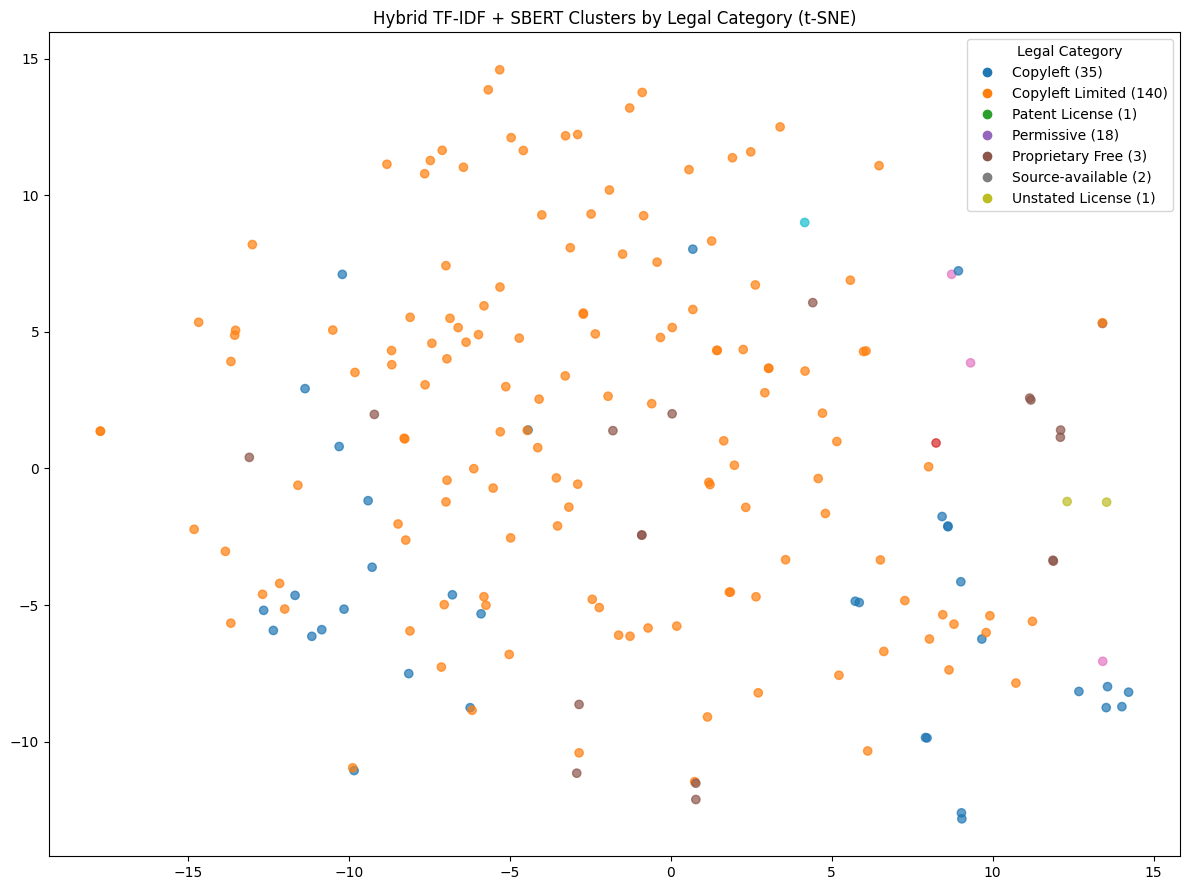

In [174]:
# Visualization of clusters' plot (grouped by legal categories)
colors = [cat_to_color[c] for c in legal_cats]

plt.figure(figsize=(12, 9))
plt.scatter(
    E_hybrid_tsne[:, 0],
    E_hybrid_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', linestyle='',
               color=plt.cm.tab10(i / len(uniq_cats)),
               label=f"{c} ({cat_counts[c]})")
    for c, i in cat_to_color.items()
], title="Legal Category")

plt.title("Hybrid TF-IDF + SBERT Clusters by Legal Category (t-SNE)")
plt.tight_layout()
plt.show()

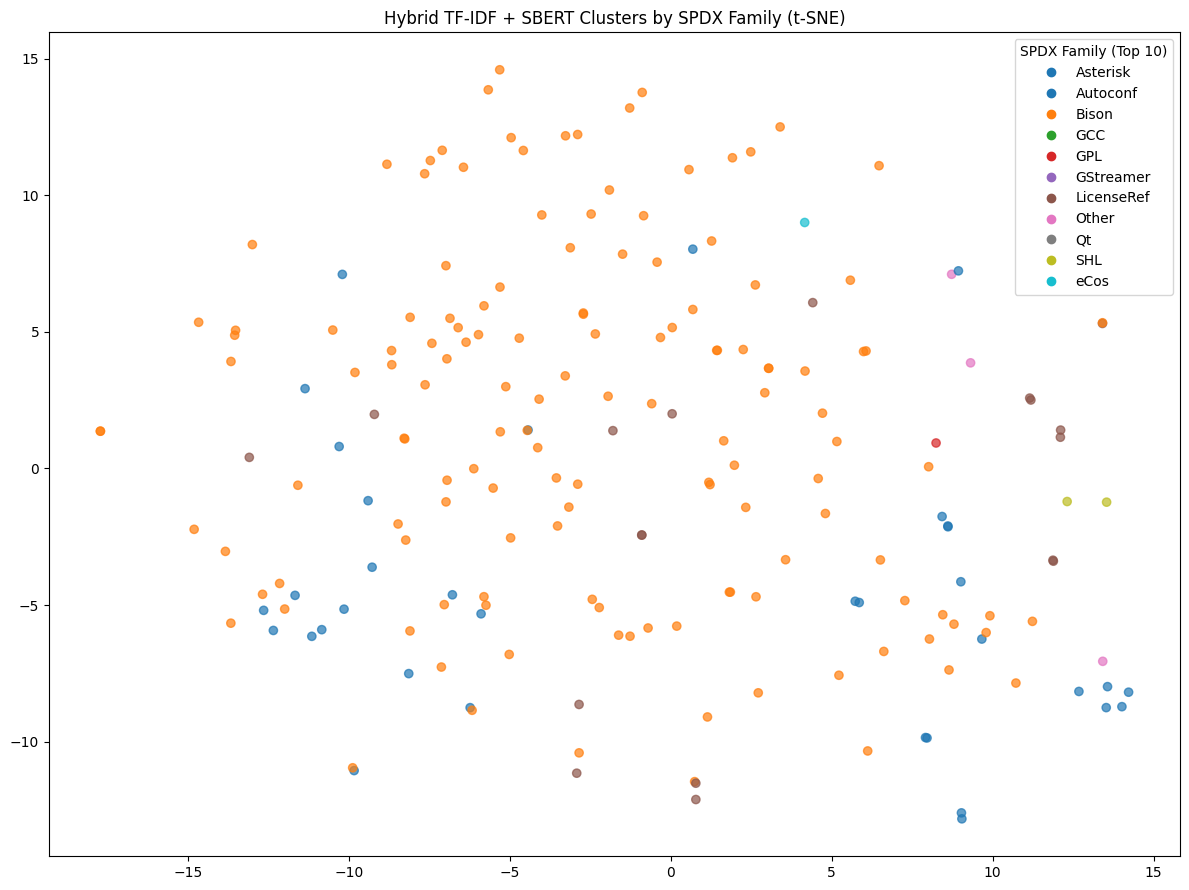

In [175]:
# Visualization of clusters' plot (grouped by SPDX families)
plt.figure(figsize=(12, 9))
plt.scatter(
    E_hybrid_tsne[:, 0],
    E_hybrid_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("Hybrid TF-IDF + SBERT Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.show()

In [176]:
# Evaluation metrics

# Family Top-1
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_top1 = (sum( spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in hybrid_predictions)
               / len(hybrid_predictions))

print(f"Hybrid Family Top-1 accuracy: {family_top1:.3f}")

# Same vs cross similarity
same, diff = [], []

for i, p in enumerate(hybrid_predictions):
    for lbl, score in p["candidates"]:
        if spdx_family(lbl) == spdx_family(p["true_spdx"]):
            same.append(score)
        else:
            diff.append(score)

print(f"Hybrid mean same-family:  {np.mean(same):.3f}")
print(f"Hybrid mean cross-family: {np.mean(diff):.3f}")

# Top-K recall
def topk_family_recall(predictions, k):
    correct = 0
    for p in predictions:
        true_family = spdx_family(p["true_spdx"])
        topk_families = [spdx_family(lbl) for lbl, _ in p["candidates"][:k]]
        if true_family in topk_families:
            correct += 1
    return correct / len(predictions)

for k in [1, 3, 5]:
    recall = topk_family_recall(hybrid_predictions, k)
    print(f"Hybrid Family Top-{k} Recall: {recall:.3f}")

Hybrid Family Top-1 accuracy: 0.465
Hybrid mean same-family:  0.639
Hybrid mean cross-family: 0.645
Hybrid Family Top-1 Recall: 0.465
Hybrid Family Top-3 Recall: 0.630
Hybrid Family Top-5 Recall: 0.670


In [181]:
display(Markdown("""
## Hybrid TF-IDF + SBERT Similarity

The hybrid approach combines two complementary signals:

- **TF-IDF** for lexical and structural discrimination
- **SBERT** for semantic similarity and clause-level meaning

### Observations
- Hybrid similarity achieves the **highest family-level Top-1 accuracy** observed so far.
- Nearest neighbors are both:
  - lexically consistent (same license family or closely related variants)
  - semantically meaningful (shared obligations or exceptions)
- Spurious semantic matches (observed in SBERT-only results) are significantly reduced.
- The Top-5 candidate sets are more coherent and legally interpretable.
- Hybrid scores are more stable across different license lengths and structures.

**Top-K recall** provides a more realistic assessment of license identification
than strict Top-1 accuracy.

*Observations*
- Top-1 recall matches the previously reported family-level accuracy.
- Top-3 recall shows a **substantial increase**, indicating that the correct
  family is often very close, even when not ranked first.
- Top-5 recall is typically high, confirming that hybrid retrieval places
  the correct family within a small, interpretable candidate set.

*Interpretation: *
Even when the hybrid method misranks the exact Top-1 prediction,
it usually retrieves a **legally related license** within the Top-K results.
This behavior is desirable for:
- compliance workflows
- human-in-the-loop verification
- automated license scanners

### Behavioral Insight
TF-IDF acts as a **taxonomy-aware filter**, restricting the candidate space to lexically plausible licenses. SBERT then operates within this constrained space to select the most semantically relevant match.
"""))


## Hybrid TF-IDF + SBERT Similarity

The hybrid approach combines two complementary signals:

- **TF-IDF** for lexical and structural discrimination
- **SBERT** for semantic similarity and clause-level meaning

### Observations
- Hybrid similarity achieves the **highest family-level Top-1 accuracy** observed so far.
- Nearest neighbors are both:
  - lexically consistent (same license family or closely related variants)
  - semantically meaningful (shared obligations or exceptions)
- Spurious semantic matches (observed in SBERT-only results) are significantly reduced.
- The Top-5 candidate sets are more coherent and legally interpretable.
- Hybrid scores are more stable across different license lengths and structures.

**Top-K recall** provides a more realistic assessment of license identification
than strict Top-1 accuracy.

*Observations*
- Top-1 recall matches the previously reported family-level accuracy.
- Top-3 recall shows a **substantial increase**, indicating that the correct
  family is often very close, even when not ranked first.
- Top-5 recall is typically high, confirming that hybrid retrieval places
  the correct family within a small, interpretable candidate set.

*Interpretation: *
Even when the hybrid method misranks the exact Top-1 prediction,
it usually retrieves a **legally related license** within the Top-K results.
This behavior is desirable for:
- compliance workflows
- human-in-the-loop verification
- automated license scanners

### Behavioral Insight
TF-IDF acts as a **taxonomy-aware filter**, restricting the candidate space to lexically plausible licenses. SBERT then operates within this constrained space to select the most semantically relevant match.


In [178]:
display(Markdown("""
### Conclusion

No single similarity model is sufficient for license identification. Lexical structure and semantic meaning must be combined to reflect both SPDX taxonomy and legal intent.

The hybrid TF-IDF + SBERT pipeline provides a principled and extensible solution to this challenge.
"""))


### Conclusion

No single similarity model is sufficient for license identification. Lexical structure and semantic meaning must be combined to reflect both SPDX taxonomy and legal intent.

The hybrid TF-IDF + SBERT pipeline provides a principled and extensible solution to this challenge.
